In [ ]:
! pip install SimpleITK
! pip install nibabel

In [59]:
import SimpleITK as sitk
import numpy as np
from scipy import ndimage
import math
import cv2
import random
import sys
import math
import requests
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import nibabel as nib
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler


from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from torchvision import datasets, models, transforms
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression


In [98]:
%run "C:\Users\johnm\Downloads\utils.ipynb"  #tarang

# Merging images with label in one dictionary

In [61]:
# tarang updated this to make it a function

def make_dict(directory, multi_fold = False, dict_images = {}):

  if multi_fold:
    print('fold')
    folds = os.listdir(directory)
    for f in folds:
      fold_path = os.path.join(directory, f)
      print(fold_path)
      make_dict(fold_path, False, dict_images)
    return dict_images
  else:
    print('datapoint')
    for folder in os.listdir(directory):
        folder_path = os.path.join(directory, folder) # /Users/kimberlyllajarunaperalta/Documents/ComputerVision/project/picai_public_images_fold1/10010/10010_1000010
        if os.path.isdir(folder_path):
            for file_name in os.listdir(folder_path):
                if "t2w" in file_name and file_name.endswith('.mha'):
                    full_path = os.path.join(directory, folder, file_name)
                    if os.path.exists(full_path):
                        short_name = '_'.join(file_name.split('_')[:2])
                        image = sitk.ReadImage(full_path)
                        dict_images[short_name] = {'image': image, 'case_pca': None, 'patient_age': None, 'age_group': None, 'patient_id': None}
    return dict_images


In [62]:
dict_images = {}

directory = "D:\Downloads\Luna Training Data"
folds = os.listdir(directory)

# print(folds)

dict_images = make_dict(directory, True, dict_images)

<>:3: SyntaxWarning: invalid escape sequence '\D'
<>:3: SyntaxWarning: invalid escape sequence '\D'
C:\Users\johnm\AppData\Local\Temp\ipykernel_18320\2235566032.py:3: SyntaxWarning: invalid escape sequence '\D'
  directory = "D:\Downloads\Luna Training Data"


fold
D:\Downloads\Luna Training Data\picai_public_images_fold0
datapoint
D:\Downloads\Luna Training Data\picai_public_images_fold1
datapoint
D:\Downloads\Luna Training Data\picai_public_images_fold2
datapoint
D:\Downloads\Luna Training Data\picai_public_images_fold3
datapoint
D:\Downloads\Luna Training Data\picai_public_images_fold4
datapoint


In [63]:
print(list(dict_images.keys())[0])

dict_images[list(dict_images.keys())[0]]

10000_1000000


{'image': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x00000217BC2D3ED0> >,
 'case_pca': None,
 'patient_age': None,
 'age_group': None,
 'patient_id': None}

In [64]:
#size of the dictionary
len(dict_images)

1500

We stored 3 things:
* the nii files that have the color coded images
* the labels for each image (from csv file)
* the age of patients for each image (from csv file)

# Using the CSV file to get the labels and patients' age

In this spreadsheet, there is a column "lesion_GS", which lists the outcomes:

Gleason score (GS) assigned to each lesion after histopathologic analysis, where scores for different lesions are separated by , (commas). If its value is missing, then no tissue sampling procedure was performed; indicating a negative MRI study. If its value is N/A only for specific lesion(s), then those lesion(s) (as observed in radiology) were not biopsied or graded in histopathology (typically the case for PI-RADS 1-2 lesions).

This means that any case that contains a Gleason score of 7 (3+4 or higher) harbors csPCa, while all other cases are considered negative for csPCa. For more details on how this ground truth was derived, you can also check out our study design.


In [65]:
# tarang

labels_path = "C:\\Users\johnm\Downloads\marksheet.csv"

<>:3: SyntaxWarning: invalid escape sequence '\j'
<>:3: SyntaxWarning: invalid escape sequence '\j'
C:\Users\johnm\AppData\Local\Temp\ipykernel_18320\299217126.py:3: SyntaxWarning: invalid escape sequence '\j'
  labels_path = "C:\\Users\johnm\Downloads\marksheet.csv"


In [66]:
df = pd.read_csv(labels_path)

In [67]:
df.head(100)

,patient_id,study_id,mri_date,patient_age,psa,psad,prostate_volume,histopath_type,lesion_GS,lesion_ISUP,case_ISUP,case_csPCa
0,10000,1000000,2019-07-02,73,7.70,NaN,55.0,MRBx,0+0,0,0,NO
1,10001,1000001,2016-05-27,64,8.70,0.09,102.0,NaN,NaN,NaN,0,NO
2,10002,1000002,2021-04-18,58,4.20,0.06,74.0,NaN,NaN,NaN,0,NO
3,10003,1000003,2019-04-05,72,13.00,NaN,71.5,SysBx,0+0,0,0,NO
4,10004,1000004,2020-10-21,67,8.00,0.10,78.0,SysBx+MRBx,"0+0,0+0","0,0",0,NO
...,...,...,...,...,...,...,...,...,...,...,...,...
95,10095,1000095,2017-02-09,65,9.20,NaN,60.0,MRBx,0+0,0,0,NO
96,10096,1000096,2011-12-31,64,22.33,0.66,34.0,MRBx,0+0,0,0,NO
97,10097,1000097,2018-11-27,66,15.01,NaN,32.0,MRBx,3+4,2,2,YES
98,10098,1000098,2012-03-29,69,12.00,0.17,69.0,NaN,NaN,NaN,0,NO


### Evaluating class imbalance

In [68]:
df['case_csPCa'].value_counts()

case_csPCa
NO     1075
YES     425
Name: count, dtype: int64

Combining them both

## Combining patient_id and study_id to get the full differentiator per patient

In [69]:
df['full_name'] = df['patient_id'].astype(str) + '_' + df['study_id'].astype(str)

In [70]:
df

,patient_id,study_id,mri_date,patient_age,psa,psad,prostate_volume,histopath_type,lesion_GS,lesion_ISUP,case_ISUP,case_csPCa,full_name
0,10000,1000000,2019-07-02,73,7.70,NaN,55.0,MRBx,0+0,0,0,NO,10000_1000000
1,10001,1000001,2016-05-27,64,8.70,0.09,102.0,NaN,NaN,NaN,0,NO,10001_1000001
2,10002,1000002,2021-04-18,58,4.20,0.06,74.0,NaN,NaN,NaN,0,NO,10002_1000002
3,10003,1000003,2019-04-05,72,13.00,NaN,71.5,SysBx,0+0,0,0,NO,10003_1000003
4,10004,1000004,2020-10-21,67,8.00,0.10,78.0,SysBx+MRBx,"0+0,0+0","0,0",0,NO,10004_1000004
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,11471,1001495,2012-08-25,71,12.50,0.21,62.0,MRBx,"3+4,N/A,3+3","2,1",2,YES,11471_1001495
1496,11472,1001496,2019-06-28,81,5.28,0.12,44.0,SysBx+MRBx,3+4,2,2,YES,11472_1001496
1497,11473,1001497,2017-09-24,56,29.60,0.34,87.0,MRBx,0+0,0,0,NO,11473_1001497
1498,11474,1001498,2016-05-03,71,12.00,NaN,83.0,MRBx,3+3,1,1,NO,11474_1001498


### Testing

In [71]:
specific_full_name = '10000_1000000'
case_csPCA_value = df.loc[df['full_name'] == specific_full_name, 'case_csPCa'].iloc[0]
case_csPCA_value

'NO'

## Adding to a dictionary based on their full name

In [72]:
not_found = 0
found = 0

for f in df['full_name']:
    if f in dict_images:
        print(f"Found {f}")
        case_csPCa_value = df.loc[df['full_name'] == f, 'case_csPCa'].iloc[0]
        patient_age = df.loc[df['full_name'] == f, 'patient_age'].iloc[0]
        #converting to 0 and 1
        dict_images[f]['case_pca'] = 0 if case_csPCa_value == 'NO' else 1 if case_csPCa_value == 'YES' else None
        dict_images[f]['patient_age'] = patient_age
        dict_images[f]['patient_id'] = f

        found += 1
    else:
        print(f"Could not find {f}")
        not_found += 1

Found 10000_1000000
Found 10001_1000001
Found 10002_1000002
Found 10003_1000003
Found 10004_1000004
Found 10005_1000005
Found 10006_1000006
Found 10007_1000007
Found 10008_1000008
Found 10009_1000009
Found 10010_1000010
Found 10011_1000011
Found 10012_1000012
Found 10013_1000013
Found 10014_1000014
Found 10015_1000015
Found 10016_1000016
Found 10017_1000017
Found 10018_1000018
Found 10019_1000019
Found 10020_1000020
Found 10021_1000021
Found 10022_1000022
Found 10023_1000023
Found 10024_1000024
Found 10025_1000025
Found 10026_1000026
Found 10027_1000027
Found 10028_1000028
Found 10029_1000029
Found 10030_1000030
Found 10031_1000031
Found 10032_1000032
Found 10033_1000033
Found 10034_1000034
Found 10035_1000035
Found 10036_1000036
Found 10037_1000037
Found 10038_1000038
Found 10039_1000039
Found 10040_1000040
Found 10041_1000041
Found 10042_1000042
Found 10043_1000043
Found 10044_1000044
Found 10045_1000045
Found 10046_1000046
Found 10047_1000047
Found 10048_1000048
Found 10049_1000049


In [73]:
found, not_found

(1500, 0)

In [99]:
dict_images

{'10000_1000000': {'image': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x00000217BC2D3ED0> >,
  'case_pca': 0,
  'patient_age': 73,
  'age_group': None,
  'patient_id': '10000_1000000'},
 '10001_1000001': {'image': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x0000020D976A4330> >,
  'case_pca': 0,
  'patient_age': 64,
  'age_group': None,
  'patient_id': '10001_1000001'},
 '10003_1000003': {'image': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x00000217BC2D3F60> >,
  'case_pca': 0,
  'patient_age': 72,
  'age_group': None,
  'patient_id': '10003_1000003'},
 '10006_1000006': {'image': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x00000217BC2D3D20> >,
  'case_pca': 0,
  'patient_age': 73,
  'age_group': None,
  'patient_id': '10006_1000006'},
 '10017_1000017': {'image': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'i

### Evaluating class imbalance in final sample

In [75]:
def balance_checker(current_dictionary, return_counts = False):
    # Extract 'case_pca' values from dictionary values
    case_pca_values = [item['case_pca'] for item in current_dictionary.values()]

    # Count occurrences of 'YES' and 'NO'
    counts = Counter(case_pca_values)
    yes_count = counts[1]
    no_count = counts[0]

    if return_counts:
        return yes_count, no_count
    else:
        print(f"Count of 'YES': {yes_count}")
        print(f"Count of 'NO': {no_count}")


In [76]:
balance_checker(dict_images)

Count of 'YES': 425
Count of 'NO': 1075


In [77]:
#our dictionary with the T2w images and the case_csPCa values
dict_images

{'10000_1000000': {'image': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x00000217BC2D3ED0> >,
  'case_pca': 0,
  'patient_age': 73,
  'age_group': None,
  'patient_id': '10000_1000000'},
 '10001_1000001': {'image': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x0000020D976A4330> >,
  'case_pca': 0,
  'patient_age': 64,
  'age_group': None,
  'patient_id': '10001_1000001'},
 '10003_1000003': {'image': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x00000217BC2D3F60> >,
  'case_pca': 0,
  'patient_age': 72,
  'age_group': None,
  'patient_id': '10003_1000003'},
 '10006_1000006': {'image': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x00000217BC2D3D20> >,
  'case_pca': 0,
  'patient_age': 73,
  'age_group': None,
  'patient_id': '10006_1000006'},
 '10017_1000017': {'image': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'i

In [78]:
dict_images[list(dict_images.keys())[0]]

{'image': <SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'itk::simple::Image *' at 0x00000217BC2D3ED0> >,
 'case_pca': 0,
 'patient_age': 73,
 'age_group': None,
 'patient_id': '10000_1000000'}

# Image Processing and Train Test Split

In [113]:
def preprocess_data(data):
    images, labels, ages = [], [], []

    for entry in data.values():
        image = forresnet(entry['image'], False)
        label = entry['case_pca']
        age = entry['patient_age']
        images.append(image)
        labels.append(label)
        ages.append(age)

    X_train, X_test, y_train, y_test, age_train, age_test = train_test_split(images, labels, ages, test_size = 0.2, random_state = 42)
    X_train, X_val, y_train, y_val, age_train, age_val = train_test_split(X_train, y_train, age_train, test_size = 0.2, random_state = 42)

    X_train = np.array(X_train)
    X_val = np.array(X_val)
    X_test = np.array(X_test)
    y_train = np.array(y_train)
    y_val = np.array(y_val)
    y_test = np.array(y_test)
    age_train = np.array(age_train)
    age_val = np.array(age_val)
    age_test = np.array(age_test)

    return X_train, X_val, X_test, y_train, y_val, y_test, age_train, age_val, age_test

In [114]:
X_train, X_val, X_test, y_train, y_val, y_test, age_train, age_val, age_test = preprocess_data(dict_images)

# Evaluating class imbalance in train, test, and validation sets

In [102]:
# Count labels in X_train
train_label_counts = Counter(y_train)
print("Train Label Counts:", train_label_counts)

# Count labels in X_val
val_label_counts = Counter(y_val)
print("Validation Label Counts:", val_label_counts)

# Count labels in X_test
test_label_counts = Counter(y_test)
print("Test Label Counts:", test_label_counts)


Train Label Counts: Counter({0: 701, 1: 259})
Validation Label Counts: Counter({0: 166, 1: 74})
Test Label Counts: Counter({0: 208, 1: 92})


In [82]:
X_train.shape, X_val.shape, X_test.shape

((960, 224, 224, 3), (240, 224, 224, 3), (300, 224, 224, 3))

## Addressing Class Imbalance in Train set
Done after train-test split to avoid data leakage.

In [83]:
def resample_train_data(X_train, y_train, age_train, upsampling = True, random_state = 42):

    #getting majority and minority classes
    unique_classes, class_counts = np.unique(y_train, return_counts=True)
    majority_label = unique_classes[np.argmax(class_counts)]
    minority_label = unique_classes[np.argmin(class_counts)]

    majority_indices = np.where(y_train == majority_label)[0]
    minority_indices = np.where(y_train == minority_label)[0]
    # print(majority_indices)
    # print(minority_indices)

    if upsampling:
        minority_upsampled_indices = resample(minority_indices, replace = True, n_samples = len(majority_indices), random_state = random_state)
        resampled_indices = np.concatenate((majority_indices, minority_upsampled_indices))
    else:
        majority_downsampled_indices = resample(majority_indices, replace = False, n_samples = len(minority_indices), random_state = random_state)
        resampled_indices = np.concatenate((majority_downsampled_indices, minority_indices))

    #selecting the samples corresponding to the resampled indices
    X_train_resampled = X_train[resampled_indices]
    y_train_resampled = y_train[resampled_indices]
    age_train_resampled = age_train[resampled_indices]

    return X_train_resampled, y_train_resampled, age_train_resampled


In [84]:
def more_cancer_samples(X_train, y_train, age_train, proportion = 1.25, random_state = 42):
    cancer_indeces = np.where(y_train == 1)[0]
    no_cancer_indeces = np.where(y_train == 0)[0]

    desired_cancer_indeces = int(proportion * len(no_cancer_indeces))

    #upsampling the cancer class to match the given proportion
    cancer_upsampled_indices = resample(
        cancer_indeces, replace = True, n_samples = desired_cancer_indeces, random_state = random_state)

    #combining minority upsampled indices with majority indices
    adjusted_indices = np.concatenate((no_cancer_indeces, cancer_upsampled_indices))

    #selecting the corresponding samples from the original data
    X_adjusted = X_train[adjusted_indices]
    y_adjusted = y_train[adjusted_indices]
    age_adjusted = age_train[adjusted_indices]

    return X_adjusted, y_adjusted, age_adjusted

In [85]:
def list_balance_checker(X_train, y_train, age_train):
    print("X_train shape:", X_train.shape)
    print("y_train shape:", y_train.shape)
    print("age_train shape:", age_train.shape)

    counts = np.bincount(y_train)
    print('Number of 0:', counts[0])
    print('Number of 1:', counts[1])

### Upsampling

In [103]:
### Before upsampling
list_balance_checker(X_train, y_train, age_train)

X_train shape: (960, 224, 224, 3)
y_train shape: (960,)
age_train shape: (960,)
Number of 0: 701
Number of 1: 259


In [115]:
### Upsampling
uX_train, uy_train, uage_train = resample_train_data(X_train, y_train, age_train, upsampling = True)

### Downsampling
dX_train, dy_train, dage_train = resample_train_data(X_train, y_train, age_train, upsampling = False)

### Upsamping > Cancer
mX_train, my_train, mage_train = more_cancer_samples(X_train, y_train, age_train)


In [116]:
print("Upsampled:")
list_balance_checker(uX_train, uy_train, uage_train)

print("Downsampled")
list_balance_checker(dX_train, dy_train, dage_train)

print("More Cancer")
list_balance_checker(mX_train, my_train, mage_train)

Upsampled:
X_train shape: (1402, 224, 224, 3)
y_train shape: (1402,)
age_train shape: (1402,)
Number of 0: 701
Number of 1: 701
Downsampled
X_train shape: (518, 224, 224, 3)
y_train shape: (518,)
age_train shape: (518,)
Number of 0: 259
Number of 1: 259
More Cancer
X_train shape: (1577, 224, 224, 3)
y_train shape: (1577,)
age_train shape: (1577,)
Number of 0: 701
Number of 1: 876


In [117]:
print("middle slice")
model = get_model(0.001)
early_stopping = EarlyStopping(monitor='val_loss', patience = 6, restore_best_weights = True)

# Train the model
history = model.fit(uX_train, uy_train,
                epochs=10,
                batch_size=64,
                validation_data=(X_val, y_val),
                callbacks = [early_stopping])

midslice = model

test_loss, test_acc = midslice.evaluate(X_test, y_test)
print({'loss' : test_loss,
                          'accuracy' : test_acc})

middle slice
Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.5075 - loss: 0.7887 - val_accuracy: 0.4250 - val_loss: 0.7398
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.5362 - loss: 0.6841 - val_accuracy: 0.5500 - val_loss: 0.6853
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.6415 - loss: 0.6393 - val_accuracy: 0.6625 - val_loss: 0.6437
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.6369 - loss: 0.6225 - val_accuracy: 0.5625 - val_loss: 0.6920
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.7052 - loss: 0.5873 - val_accuracy: 0.3875 - val_loss: 0.8225
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.6717 - loss: 0.5915 - val_accuracy: 0.5792 - val_loss: 0.7055
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.7219 - loss: 0.5614 - val_accuracy: 0.5250 - val_loss: 0.7473
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.7225 - loss: 0.5542 - val_accuracy: 0.379

In [111]:
print("first slice")
model = get_model(0.001)
early_stopping = EarlyStopping(monitor='val_loss', patience = 6, restore_best_weights = True)

# Train the model
history = model.fit(uX_train, uy_train,
                epochs=10,
                batch_size=64,
                validation_data=(X_val, y_val),
                callbacks = [early_stopping])

firslice = model

test_loss, test_acc = firslice.evaluate(X_test, y_test)
print({'loss' : test_loss,
                          'accuracy' : test_acc})

first slice
Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.4980 - loss: 0.7810 - val_accuracy: 0.6917 - val_loss: 0.6430
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.5532 - loss: 0.6771 - val_accuracy: 0.5208 - val_loss: 0.6951
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 39s 2s/step - accuracy: 0.5912 - loss: 0.6629 - val_accuracy: 0.7000 - val_loss: 0.6101
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.5939 - loss: 0.6625 - val_accuracy: 0.6083 - val_loss: 0.6632
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.6652 - loss: 0.6188 - val_accuracy: 0.5625 - val_loss: 0.6905
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.6711 - loss: 0.6090 - val_accuracy: 0.4625 - val_loss: 0.7361
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.6847 - loss: 0.6027 - val_accuracy: 0.6208 - val_loss: 0.6500
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.6778 - loss: 0.6003 - val_accuracy: 0.3958

44/44 ━━━━━━━━━━━━━━━━━━━━ 37s 800ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 712ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 706ms/step


,Accuracy,Precision,Recall,F1 Score
Set Type,,,,
Train,0.656205,0.819242,0.400856,0.538314
Validation,0.662500,0.422222,0.256757,0.319328
Test,0.690000,0.487805,0.217391,0.300752


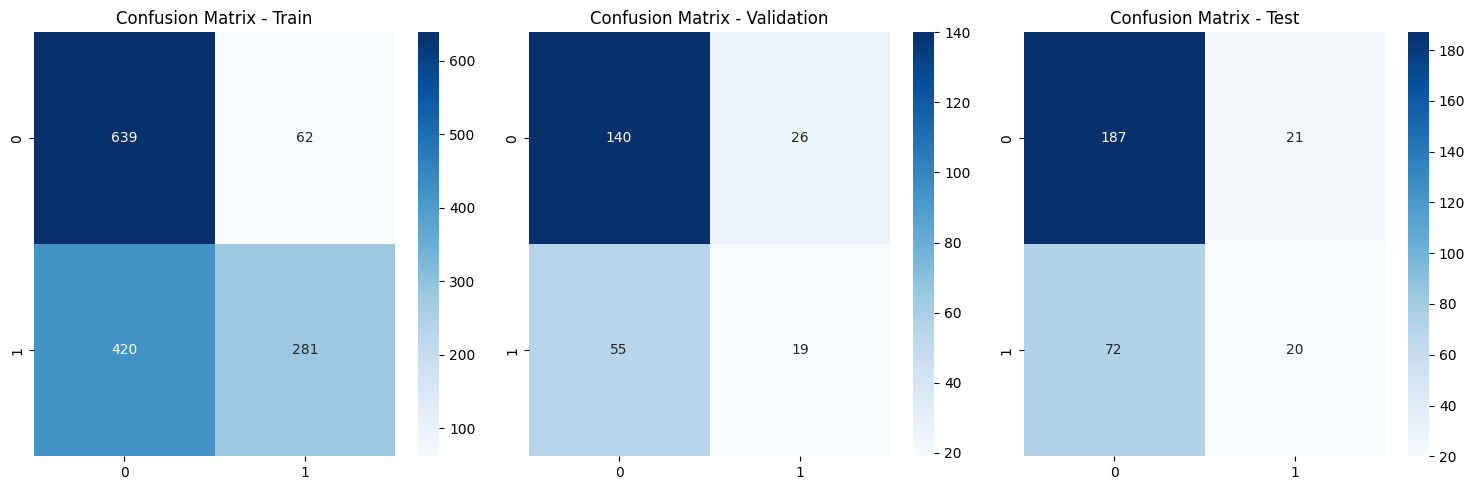

(            Accuracy  Precision    Recall  F1 Score
 Set Type                                           
 Train       0.656205   0.819242  0.400856  0.538314
 Validation  0.662500   0.422222  0.256757  0.319328
 Test        0.690000   0.487805  0.217391  0.300752,
 [[0,
   1,
   2,
   3,
   4,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   15,
   16,
   17,
   18,
   19,
   20,
   21,
   22,
   23,
   24,
   25,
   26,
   27,
   28,
   29,
   30,
   31,
   32,
   33,
   34,
   35,
   37,
   38,
   39,
   40,
   42,
   43,
   44,
   45,
   46,
   47,
   48,
   49,
   50,
   51,
   52,
   53,
   54,
   55,
   56,
   57,
   58,
   59,
   60,
   61,
   62,
   63,
   64,
   66,
   67,
   68,
   69,
   70,
   71,
   72,
   73,
   74,
   75,
   76,
   77,
   78,
   80,
   81,
   82,
   83,
   84,
   85,
   86,
   87,
   88,
   89,
   90,
   91,
   92,
   93,
   94,
   96,
   97,
   98,
   99,
   100,
   101,
   102,
   105,
   106,
   107,
   108,
   109,
   110,
   111,

In [118]:
evaluate_model(midslice, 0.5, uX_train, uy_train, X_val, y_val, X_test, y_test, include_test = True)

44/44 ━━━━━━━━━━━━━━━━━━━━ 37s 796ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 717ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 726ms/step


,Accuracy,Precision,Recall,F1 Score
Set Type,,,,
Train,0.606277,0.732087,0.335235,0.459883
Validation,0.700000,0.526316,0.270270,0.357143
Test,0.633333,0.350000,0.228261,0.276316


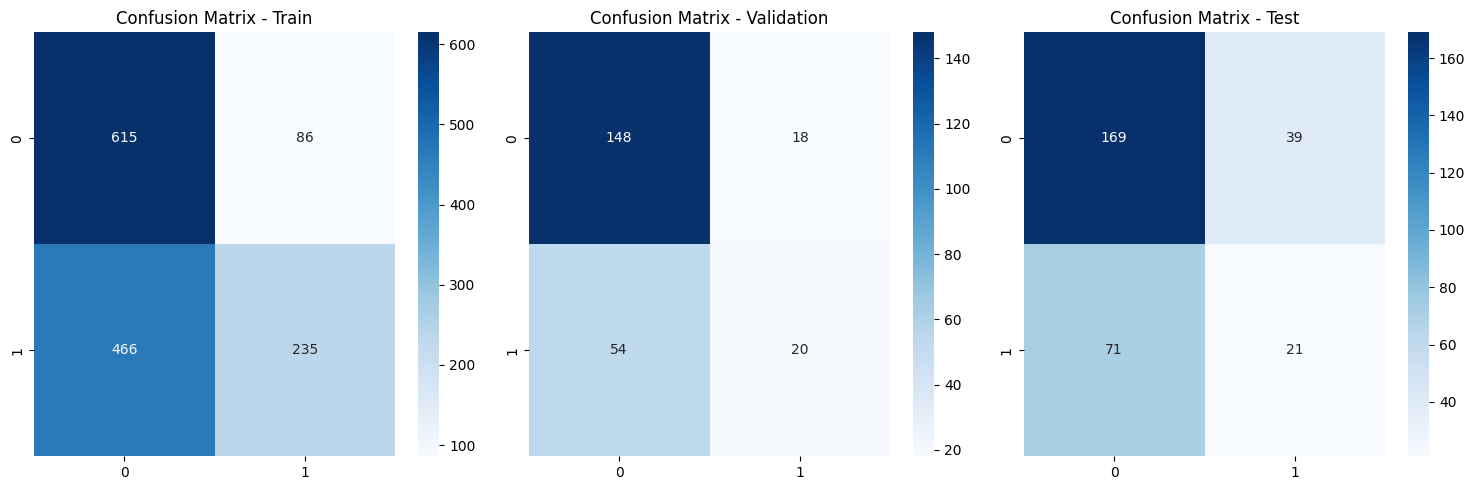

(            Accuracy  Precision    Recall  F1 Score
 Set Type                                           
 Train       0.606277   0.732087  0.335235  0.459883
 Validation  0.700000   0.526316  0.270270  0.357143
 Test        0.633333   0.350000  0.228261  0.276316,
 [[0,
   1,
   2,
   3,
   4,
   5,
   6,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   17,
   18,
   19,
   20,
   22,
   23,
   24,
   25,
   26,
   27,
   28,
   29,
   30,
   31,
   32,
   33,
   34,
   35,
   36,
   37,
   38,
   39,
   40,
   42,
   43,
   45,
   46,
   47,
   49,
   50,
   51,
   52,
   53,
   54,
   55,
   56,
   57,
   59,
   60,
   61,
   62,
   63,
   64,
   66,
   68,
   69,
   70,
   71,
   72,
   74,
   75,
   76,
   77,
   79,
   80,
   81,
   82,
   83,
   84,
   85,
   88,
   89,
   90,
   91,
   92,
   93,
   94,
   95,
   96,
   97,
   98,
   99,
   100,
   101,
   102,
   103,
   104,
   105,
   106,
   108,
   110,
   111,
   112,
   113,
   115,
   116,
   117,
   118,
   119,
   12

In [112]:
evaluate_model(firslice, 0.5, uX_train, uy_train, X_val, y_val, X_test, y_test, include_test = True)

# Baseline Model: ResNet50

# Experiment 1: Hyperparameter Training

In [ ]:
# for upsampling, downsampling, and more cancer:

# learning rates: (0.01, 0.005, 0.001, 0.0001?)
# batch size (16, 32, 64)
# epochs (10, 40, 70)

In [ ]:
# function form of model code

def get_model(learning_rate, verbose = False):
  # Load pre-trained ResNet-50 model without top layers
  base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

  # Freeze the base model layers
  for layer in base_model.layers:
    layer.trainable = False

  # Add new classification layers
  x = base_model.output
  x = GlobalAveragePooling2D()(x)  # Add a global average pooling layer
  x = Dense(128, activation='relu')(x)  # Add a dense layer
  predictions = Dense(1, activation='sigmoid')(x)  # Add an output layer for binary classification

  # Combine the base model and new layers
  model = Model(inputs=base_model.input, outputs=predictions)

  # Compile the model
  model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

  # Print model summary
  if verbose:
    model.summary()

  return model


In [ ]:
def run_hypers(X_train, y_train):
  lrms = {}
  batchms = {}
  epochms = {}

  for lr in lrs:
    print("training with lr: ", lr)
    model = get_model(lr)
    early_stopping = EarlyStopping(monitor='val_loss', patience = 6, restore_best_weights = True)

    # Train the model
    history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks = [early_stopping])

    lrms[lr] = model

  for batch in batches:
    print("training with batch size: ", batch)
    model = get_model(0.001)
    early_stopping = EarlyStopping(monitor='val_loss', patience = 6, restore_best_weights = True)

    # Train the model
    history = model.fit(X_train, y_train,
                      epochs=10,
                      batch_size=batch,
                      validation_data=(X_val, y_val),
                      callbacks = [early_stopping])

    batchms[batch] = model

  for epoch in epochs:
    print("training with epochs: ", epoch)
    model = get_model(0.001)
    early_stopping = EarlyStopping(monitor='val_loss', patience = 6, restore_best_weights = True)

    # Train the model
    history = model.fit(X_train, y_train,
                      epochs=epoch,
                      batch_size=32,
                      validation_data=(X_val, y_val),
                      callbacks = [early_stopping])

    epochms[epoch] = model

  test_metrics = {}

  for lr in lrs:
    print("learning rate: ", lr)
    test_loss, test_acc = lrms[lr].evaluate(X_test, y_test)
    test_metrics["lr" + str(lr)] = {'loss' : test_loss,
                              'accuracy' : test_acc}

  for batch in batches:
    print("batch size: ", batch)
    test_loss, test_acc = batchms[batch].evaluate(X_test, y_test)
    test_metrics["batch" + str(batch)] = {'loss' : test_loss,
                              'accuracy' : test_acc}

  for epoch in epochs:
    print("epochs: ", epoch)
    test_loss, test_acc = epochms[epoch].evaluate(X_test, y_test)
    test_metrics["epoch" + str(epoch)] = {'loss' : test_loss,
                              'accuracy' : test_acc}

  return lrms, batchms, epochms, test_metrics

In [ ]:
lrs = [0.01, 0.005, 0.001, 0.0001, 0.05]
batches = [16, 32, 64]
epochs = [10, 40, 70]

## Hyper-parameter Training

In [ ]:
uplrs, upbatches, upepochs, upmetrics = run_hypers(uX_train, uy_train)

print(upmetrics)

training with lr:  0.01
Epoch 1/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 50s 931ms/step - accuracy: 0.4866 - loss: 1.5622 - val_accuracy: 0.5167 - val_loss: 0.7038
Epoch 2/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 38s 869ms/step - accuracy: 0.5820 - loss: 0.6771 - val_accuracy: 0.3333 - val_loss: 0.8986
Epoch 3/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 38s 876ms/step - accuracy: 0.5918 - loss: 0.6629 - val_accuracy: 0.6250 - val_loss: 0.6433
Epoch 4/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 41s 875ms/step - accuracy: 0.6132 - loss: 0.6481 - val_accuracy: 0.3750 - val_loss: 0.8823
Epoch 5/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 38s 869ms/step - accuracy: 0.6667 - loss: 0.6166 - val_accuracy: 0.7000 - val_loss: 0.6381
Epoch 6/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 41s 865ms/step - accuracy: 0.6301 - loss: 0.6478 - val_accuracy: 0.5125 - val_loss: 0.7184
Epoch 7/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 38s 863ms/step - accuracy: 0.6506 - loss: 0.6100 - val_accuracy: 0.5292 - val_loss: 0.6781
Epoch 8/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 38s 871ms/step - accuracy: 0.7049 -

In [ ]:
downlrs, downbatches, downepochs, downmetrics = run_hypers(dX_train, dy_train)

print(downmetrics)

training with lr:  0.01
Epoch 1/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.5554 - loss: 1.8382 - val_accuracy: 0.6917 - val_loss: 0.6845
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.4909 - loss: 0.6939 - val_accuracy: 0.6917 - val_loss: 0.6838
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.5043 - loss: 0.6932 - val_accuracy: 0.6917 - val_loss: 0.6859
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.5158 - loss: 0.6928 - val_accuracy: 0.6917 - val_loss: 0.6839
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.5182 - loss: 0.6926 - val_accuracy: 0.6917 - val_loss: 0.6840
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.4956 - loss: 0.6936 - val_accuracy: 0.6917 - val_loss: 0.6881
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.4791 - loss: 0.6937 - val_accuracy: 0.6917 - val_loss: 0.6918
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.5344 - loss: 0.6931 - val_accu

In [ ]:
morelrs, morebatches, moreepochs, moremetrics = run_hypers(mX_train, my_train)

print(moremetrics)

training with lr:  0.01
Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.4953 - loss: 1.1549 - val_accuracy: 0.3083 - val_loss: 0.7069
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 49s 983ms/step - accuracy: 0.5651 - loss: 0.6777 - val_accuracy: 0.3083 - val_loss: 0.7280
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 49s 975ms/step - accuracy: 0.5491 - loss: 0.6702 - val_accuracy: 0.3083 - val_loss: 0.7349
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 82s 975ms/step - accuracy: 0.5689 - loss: 0.6613 - val_accuracy: 0.3125 - val_loss: 0.7056
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 49s 990ms/step - accuracy: 0.5505 - loss: 0.6471 - val_accuracy: 0.6250 - val_loss: 0.7098
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 50s 996ms/step - accuracy: 0.6017 - loss: 0.6286 - val_accuracy: 0.5542 - val_loss: 0.7407
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 49s 974ms/step - accuracy: 0.6339 - loss: 0.6182 - val_accuracy: 0.6667 - val_loss: 0.6802
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 49s 977ms/step - accuracy: 0.6545 - lo

## Evaluating Best Models (TODO FROM HERE DOWN)

In [ ]:
evaluate_model(up_epochs[70], 0.5, X_train, y_train, X_val, y_val, X_test, y_test, include_test = True)

## Model with All Best Hyperparameters (Upsampling)

In [ ]:

model = get_model(0.005)

# ADD EARLY STOPPING

# Train the model
history = model.fit(X_train, y_train,
                    epochs=70,
                    batch_size=64,
                    validation_data=(X_val, y_val))

bestUpModel = model

bestUpModel

In [ ]:
test_loss, test_acc = bestUpModel.evaluate(X_test, y_test)
bestUpTestMetrics = {'loss' : test_loss,
                     'accuracy' : test_acc}

10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 673ms/step - accuracy: 0.6388 - loss: 1.2715


In [ ]:
evaluate_model(bestUpModel, 0.5, X_train, y_train, X_val, y_val, X_test, y_test, include_test = True)

## Downsampling Hyperparameter